# Wines Points prediction 

In [134]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [135]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [136]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv") #, encoding="utf-8")
wine_reviews.shape

(129971, 14)

In [137]:
wine_reviews.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [138]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
59405,59405,France,Wonderful old vines facing south and south-eas...,Vieilles Vignes,94,20.0,Beaujolais,Moulin-à-Vent,NaN,Roger Voss,@vossroger,Domaines Dominique Piron 2015 Vieilles Vignes ...,Gamay,Domaines Dominique Piron
45844,45844,US,While the concentrated flavors of peaches and ...,Dry,84,13.0,New York,Finger Lakes,Finger Lakes,Anna Lee C. Iijima,NaN,Wagner 2010 Dry Gewürztraminer (Finger Lakes),Gewürztraminer,Wagner
29806,29806,Italy,"This is a quintessential Franciacorta, featuri...",Brut Riserva Casa delle Colonne Special Cru,94,60.0,Lombardy,Franciacorta,NaN,Kerin O’Keefe,@kerinokeefe,Fratelli Berlucchi 2006 Brut Riserva Casa dell...,Sparkling Blend,Fratelli Berlucchi
48050,48050,US,"Tastes soft and high in alcohol, with flavors ...",La Storia Cuvée 32,87,25.0,California,Sonoma County,Sonoma,NaN,NaN,Trentadue 2009 La Storia Cuvée 32 Red (Sonoma ...,Red Blend,Trentadue
85103,85103,US,A touch of exotic spice gives a musky appeal t...,Reserve,89,25.0,New York,Finger Lakes,Finger Lakes,Anna Lee C. Iijima,NaN,Dr. Konstantin Frank 2011 Reserve Gewürztramin...,Gewürztraminer,Dr. Konstantin Frank


In [139]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [140]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews['description_low'] = wine_reviews['description'].str.lower()
wine_reviews.shape

(119988, 14)

## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [141]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [142]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [143]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [144]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [145]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.551626
MAE    2.525683
R2    -0.000099
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [146]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.676190
Armenia                   88.000000
Australia                 88.596820
Austria                   90.129179
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [147]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.021819
MAE    2.451798
R2     0.055374
dtype: float64

### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [148]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.793303
           Other               85.995192
Armenia    Armenia             88.000000
Australia  Australia Other     85.505263
           New South Wales     88.046875
Name: basiline_3_predicted_points, dtype: float64

In [149]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 17), (23998, 16))

In [150]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.472053
MAE    2.358464
R2     0.112937
dtype: float64

### Baselines summary

In [151]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.551626,2.525683,-0.000099
baseline_2,9.021819,2.451798,0.055374
baseline_3,8.472053,2.358464,0.112937


In [152]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [153]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [154]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [155]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [156]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

#### Fitting a tree-regressor

In [157]:
from src.models import i_feel_lucky_xgboost_training

In [158]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 0 to 129969
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int32  
 1   province     95990 non-null  int32  
 2   region_1     95990 non-null  int32  
 3   region_2     95990 non-null  int32  
 4   taster_name  95990 non-null  int32  
 5   variety      95990 non-null  int32  
 6   winery       95990 non-null  int32  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 4.8 MB


In [159]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [160]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction
3,41,218,549,6,0,480,14390,13.0,87,86
11,15,11,21,6,16,209,9963,30.0,87,88
12,41,51,14,13,19,80,10239,34.0,87,90
22,22,332,992,6,9,691,904,19.0,87,87
24,22,332,992,6,9,389,2065,35.0,87,90


In [161]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.233769
MAE    1.888074
R2     0.347296
dtype: float64

In [162]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

,MSE,MAE,R2
baseline_1,9.551626,2.525683,-0.000099
baseline_2,9.021819,2.451798,0.055374
baseline_3,8.472053,2.358464,0.112937
regression_by_xgb,6.233769,1.888074,0.347296


In [163]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

In [164]:
#Function to return string quality based on points value.
def getQuality(points):
    if(points <= 85):
        return 'A - low'
    elif(points<=90 ):
        return 'B - good'
    elif(points<=95):
        return 'C - great'
    elif(points<=100):
        return 'D -excelent'
    else:
        return 'error'
    

In [165]:
wine_reviews['quality'] = wine_reviews['points'].apply(getQuality)
label = wine_reviews['quality']

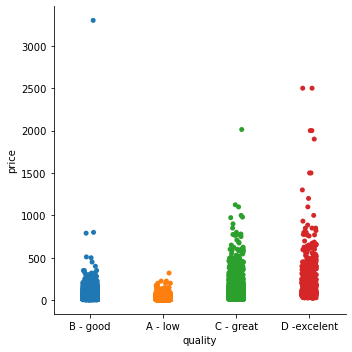

In [166]:
#Wine quality by price
import seaborn as sns
sns.catplot(x = 'quality', y = 'price', data = wine_reviews)
#check how to sort by A B C D

In [167]:
wine_reviews['description_low'] = wine_reviews['description'].str.lower()

## Classical NLP approaches

### Using only the text from the "description" column

In [168]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import nltk
import seaborn as sns
import scipy
from scipy.sparse import spmatrix
from sklearn.model_selection import train_test_split

In [169]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dzerubavel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dzerubavel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dzerubavel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [170]:
stopwords=nltk.corpus.stopwords.words("english")
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [171]:
#check if ro removed 
text_tokens = nltk.word_tokenize("wine dataset - intro.ipynb")
text_tokens

['wine', 'dataset', '-', 'intro.ipynb']

In [172]:
all_words = [word for desc in train_data.description_low for word in nltk.word_tokenize(desc) if word.lower() not in stopwords] # Words without stop words
words_df = pd.DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head()

,word,wordCount,wordImportance
0,",",326090,3.886408e-07
1,.,261238,4.851204e-07
2,wine,59054,2.146034e-06
3,flavors,46239,2.740801e-06
4,'s,38147,3.322198e-06


In [173]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 3045253 words, 41326 unique words


In [174]:
print ("Using words with 5 or more appearnces will reduce the corpus size to: {}".format(sum(words_df.wordCount >= 5)))

Using words with 5 or more appearnces will reduce the corpus size to: 12272


In [175]:
words_df = words_df[words_df.wordCount >= 5]
#clear words that are always included 's , .
words_df = words_df[words_df.wordCount < 35000]

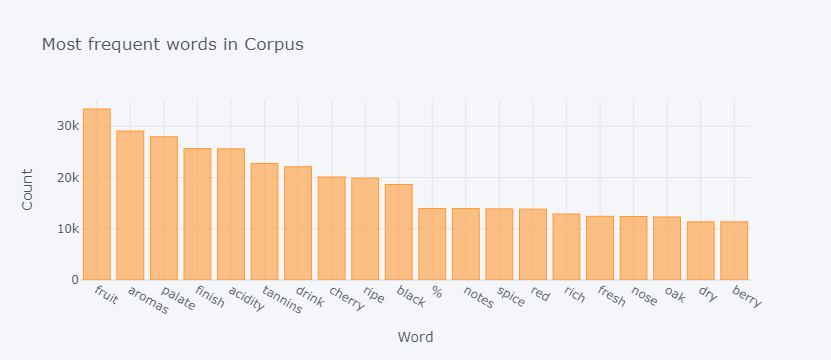

In [176]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [177]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))
#clear . , 's and so on


Total of 3045253 words, 12267 unique words


### Bag of words (One-hot-encoding)

In [178]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [179]:
clean_vocab = set(words_df.word)
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)
clean_bow_counts =  count_vect.fit_transform(wine_reviews.description_low)
clean_bow_counts_train = count_vect.fit_transform(train_data.description_low)
clean_bow_counts_test = count_vect.fit_transform(test_data.description_low)


In [180]:
print('train shape - ', clean_bow_counts_train.shape)
print('test shape - ', clean_bow_counts_test.shape)

train shape -  (95990, 12267)
test shape -  (23998, 12267)


In [181]:
print(clean_bow_counts_train[1])

  (0, 703)	1
  (0, 860)	1
  (0, 1561)	1
  (0, 1968)	1
  (0, 2145)	1
  (0, 2663)	1
  (0, 3050)	1
  (0, 4277)	1
  (0, 4357)	2
  (0, 4589)	1
  (0, 4763)	1
  (0, 4955)	1
  (0, 6381)	1
  (0, 6750)	1
  (0, 7338)	1
  (0, 7404)	1
  (0, 7493)	1
  (0, 7496)	1
  (0, 7743)	1
  (0, 7857)	1
  (0, 7881)	1
  (0, 8059)	1
  (0, 8423)	1
  (0, 9079)	1
  (0, 9499)	1
  (0, 9512)	1
  (0, 9750)	1
  (0, 9869)	1
  (0, 9953)	1
  (0, 10003)	1
  (0, 10171)	1
  (0, 10376)	1
  (0, 10797)	1
  (0, 11146)	1


## Classification

In [182]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

In [183]:
from sklearn.linear_model import LogisticRegression, Ridge


In [184]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
auc_by_alpha_ridge = []
for alpha in search_grid:
#    model = LogisticRegression(penalty='l2', C=alpha)
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, clean_bow_counts, y = wine_reviews.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    auc_by_alpha_ridge.append((alpha,avg_score))

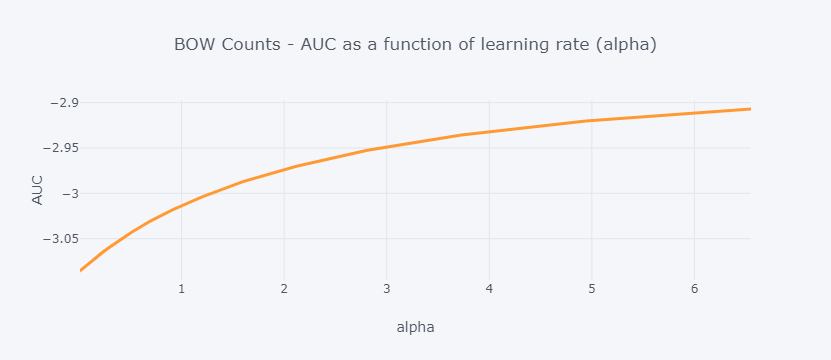

In [185]:
cv_results = pd.DataFrame(auc_by_alpha_ridge, columns = ['alpha', 'AUC'])
cv_results.query('alpha < 8').set_index('alpha').AUC.iplot(title = 'BOW Counts - AUC as a function of learning rate (alpha)', xTitle = 'alpha', yTitle = 'AUC', width = 3, hline=(0,0))

In [186]:
opt_alpha, max_auc = cv_results.loc[cv_results.AUC.idxmax()]
print(opt_alpha, -max_auc)

15.264179671752334 2.8892490951383576


In [187]:
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=15.264179671752334)

In [188]:
test_data['NLP_description_only_predicted_points'] = model.predict(clean_bow_counts_test)

In [189]:
NLP_description_only_predicted_points = calc_prediction_quality(test_data, 'NLP_description_only_predicted_points','points')
NLP_description_only_predicted_points

MSE    2.910409
MAE    1.340855
R2     0.695267
dtype: float64

In [190]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_description_only_predicted_points], index=['baseline_1', 'baseline_2','baseline_3', 'regression_by_xgb', 'NLP_description_only_predicted_points'])
all_compared


,MSE,MAE,R2
baseline_1,9.551626,2.525683,-0.000099
baseline_2,9.021819,2.451798,0.055374
baseline_3,8.472053,2.358464,0.112937
regression_by_xgb,6.233769,1.888074,0.347296
NLP_description_only_predicted_points,2.910409,1.340855,0.695267


### Feature importance

In [191]:
features

['country',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'variety',
 'winery',
 'price']

<AxesSubplot:>

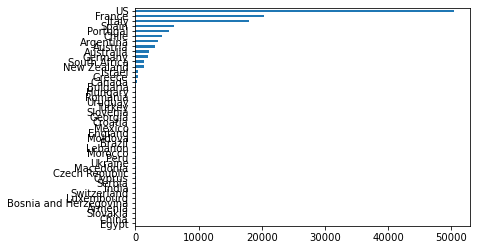

In [192]:
wine_reviews.country.value_counts().sort_values().plot(kind = 'barh')

most data is for USA and for many countries there is alsmot no records

<AxesSubplot:>

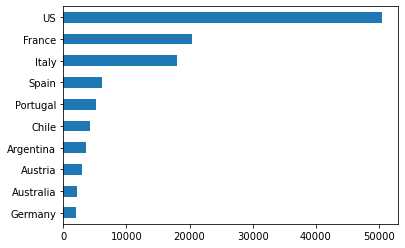

In [193]:
wine_reviews.country.value_counts().head(10).sort_values().plot(kind = 'barh')

<AxesSubplot:>

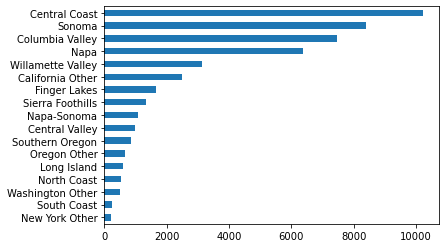

In [194]:
wine_reviews.region_2.value_counts().sort_values().plot(kind = 'barh')

region_1 contains many class values. region_2 had limitied.

<AxesSubplot:>

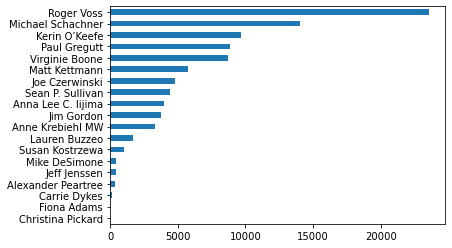

In [195]:
wine_reviews.taster_name.value_counts().sort_values().plot(kind = 'barh')

## Using Words + additinal featurs

In [196]:
from scipy.sparse import coo_matrix, hstack
from sklearn.preprocessing import StandardScaler


In [197]:
from scipy.sparse import coo_matrix, hstack

train_features_spares_matrix = coo_matrix(train_encoded_features.iloc[:,0:8])
train_united_features = hstack((clean_bow_counts_train ,train_features_spares_matrix))

test_features_spares_matrix = coo_matrix(test_encoded_features.iloc[:,0:8])
test_united_features = hstack((clean_bow_counts_test ,test_features_spares_matrix))

In [244]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
auc_by_alpha_ridge = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    #avg_score = cross_val_score(model, train_united_features, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    avg_score = abs(cross_val_score(model, train_united_features, y =train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean())
    auc_by_alpha_ridge.append((alpha,avg_score))

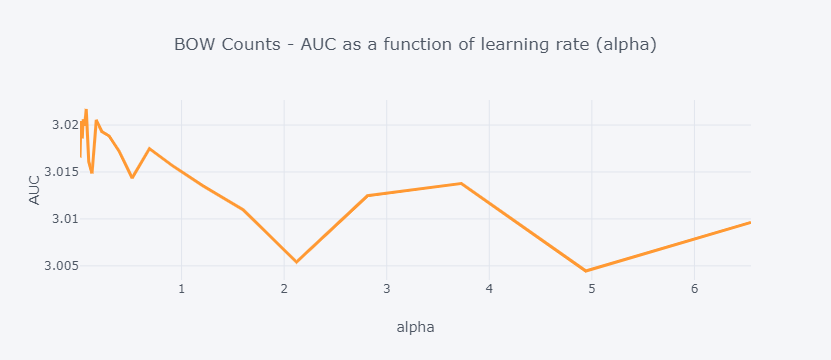

In [245]:
cv_results = pd.DataFrame(auc_by_alpha_ridge, columns = ['alpha', 'AUC'])
cv_results.query('alpha < 8').set_index('alpha').AUC.iplot(title = 'BOW Counts - AUC as a function of learning rate (alpha)', xTitle = 'alpha', yTitle = 'AUC', width = 3, hline=(0,0))

In [246]:
opt_alpha, max_auc = cv_results.loc[cv_results.AUC.idxmax()]
print(opt_alpha, -max_auc)

10000.0 -5.9724251343915515


In [247]:
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=10000.0)

In [248]:
test_data['NLP_description_and_all_features_predicted_points'] = model.predict(clean_bow_counts_test)

In [249]:
NLP_description_and_all_features_predicted_points = calc_prediction_quality(test_data, 'NLP_description_and_all_features_predicted_points','points')
NLP_description_and_all_features_predicted_points

MSE    5.838206
MAE    1.941733
R2     0.388713
dtype: float64

In [250]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_description_only_predicted_points, NLP_description_and_all_features_predicted_points], index=['baseline_1', 'baseline_2','baseline_3', 'regression_by_xgb', 'NLP_description_only_predicted_points','NLP_description_and_all_features_predicted_points'])
all_compared

,MSE,MAE,R2
baseline_1,9.551626,2.525683,-0.000099
baseline_2,9.021819,2.451798,0.055374
baseline_3,8.472053,2.358464,0.112937
regression_by_xgb,6.233769,1.888074,0.347296
NLP_description_only_predicted_points,2.910409,1.340855,0.695267
NLP_description_and_all_features_predicted_points,5.838206,1.941733,0.388713


<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

## Deep Learning approaches

### Fully connected network on the text only

#### Tokenization

In [251]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [252]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [253]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [254]:
vectorize_layer.adapt(train_data['description'])

In [255]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

Dusty mineral and bramble notes lend a savory, slightly rustic feel to this dry-style Riesling. It's delicate in body and concentration, but refreshing and zesty with lime acidity.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([ 303,  114,    2,  958,   33,  573,    4,  143,  153,  474,  181,
         13,    7, 4949,  305,   14,  267,   11,  238,    2,  243,   23,
        211,    2,  272,    6,  157,   21,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int64)>

In [256]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

303 --->  dusty
114 --->  mineral
2 --->  and
958 --->  bramble
33 --->  notes
573 --->  lend
4 --->  a
143 --->  savory
153 --->  slightly
474 --->  rustic
181 --->  feel
13 --->  to
7 --->  this
4949 --->  drystyle
305 --->  riesling
14 --->  its
267 --->  delicate
11 --->  in
238 --->  body
2 --->  and


#### Modeling

In [257]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [258]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout_8 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                

In [294]:
#tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)
#I Was not able to install as this was on work computer and the exe files for graghviz were blocked.

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [260]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [261]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 11s 14ms/step - loss: 22.0435 - mean_squared_error: 1372.2242 - mean_absolute_error: 22.0435 - val_loss: 2.4466 - val_mean_squared_error: 9.1116 - val_mean_absolute_error: 2.4466
Epoch 2/20
750/750 [==============================] - 10s 13ms/step - loss: 3.4417 - mean_squared_error: 18.6269 - mean_absolute_error: 3.4417 - val_loss: 1.7022 - val_mean_squared_error: 4.5485 - val_mean_absolute_error: 1.7022
Epoch 3/20
750/750 [==============================] - 11s 15ms/step - loss: 3.1693 - mean_squared_error: 15.7993 - mean_absolute_error: 3.1693 - val_loss: 1.5169 - val_mean_squared_error: 3.6919 - val_mean_absolute_error: 1.5169
Epoch 4/20
750/750 [==============================] - 11s 14ms/step - loss: 3.0962 - mean_squared_error: 15.1234 - mean_absolute_error: 3.0962 - val_loss: 1.4707 - val_mean_squared_error: 3.4836 - val_mean_absolute_error: 1.4707
Epoch 5/20
750/750 [==============================] - 11s 14ms/step - loss: 3.08

### Simple NN Prediction & Evaluation

In [262]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

750/750 [==============================] - 2s 2ms/step


In [263]:
calc_prediction_quality(test_data, 'dnn_prediction', target_col)

MSE    3.046938
MAE    1.377286
R2     0.680972
dtype: float64

In [264]:
dnn_prediction = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_description_only_predicted_points, NLP_description_and_all_features_predicted_points, dnn_prediction], index=['baseline_1', 'baseline_2','baseline_3', 'regression_by_xgb', 'NLP_description_only_predicted_points','NLP_description_and_all_features_predicted_points','dnn_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.551626,2.525683,-0.000099
baseline_2,9.021819,2.451798,0.055374
baseline_3,8.472053,2.358464,0.112937
regression_by_xgb,6.233769,1.888074,0.347296
NLP_description_only_predicted_points,2.910409,1.340855,0.695267
NLP_description_and_all_features_predicted_points,5.838206,1.941733,0.388713
dnn_prediction,3.046938,1.377286,0.680972


### Descriptions words concatinated

In [265]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Dropout, Embedding
from tensorflow.keras import Sequential

In [266]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding", ),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.7),
    Dense(1, name = 'output_layer')
])

In [267]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [268]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [269]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 14s 18ms/step - loss: 24.3152 - mean_squared_error: 1102.6627 - mean_absolute_error: 24.3152 - val_loss: 2.6705 - val_mean_squared_error: 11.1044 - val_mean_absolute_error: 2.6705
Epoch 2/20
750/750 [==============================] - 12s 16ms/step - loss: 8.7302 - mean_squared_error: 118.9637 - mean_absolute_error: 8.7302 - val_loss: 2.6332 - val_mean_squared_error: 10.7020 - val_mean_absolute_error: 2.6332
Epoch 3/20
750/750 [==============================] - 11s 14ms/step - loss: 8.6763 - mean_squared_error: 117.7948 - mean_absolute_error: 8.6763 - val_loss: 2.6329 - val_mean_squared_error: 10.6990 - val_mean_absolute_error: 2.6329
Epoch 4/20
750/750 [==============================] - 10s 14ms/step - loss: 8.6405 - mean_squared_error: 117.0023 - mean_absolute_error: 8.6405 - val_loss: 2.6663 - val_mean_squared_error: 11.0614 - val_mean_absolute_error: 2.6663
Epoch 5/20
750/750 [==============================] - 10s 13ms/step - los

In [270]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

750/750 [==============================] - 2s 3ms/step


In [271]:
calc_prediction_quality(test_data, 'dnn_prediction', target_col)

MSE    5.645576
MAE    1.882923
R2     0.408882
dtype: float64

In [292]:
dnn_prediction_concatinated = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_description_only_predicted_points, NLP_description_and_all_features_predicted_points, dnn_prediction, dnn_prediction_concatinated], index=['baseline_1', 'baseline_2','baseline_3', 'regression_by_xgb', 'NLP_description_only_predicted_points','NLP_description_and_all_features_predicted_points','dnn_prediction', 'dnn_prediction_concatinated'])
all_compared

,MSE,MAE,R2
baseline_1,9.551626,2.525683,-0.000099
baseline_2,9.021819,2.451798,0.055374
baseline_3,8.472053,2.358464,0.112937
regression_by_xgb,6.233769,1.888074,0.347296
NLP_description_only_predicted_points,2.910409,1.340855,0.695267
NLP_description_and_all_features_predicted_points,5.838206,1.941733,0.388713
dnn_prediction,3.046938,1.377286,0.680972
dnn_prediction_concatinated,5.645576,1.882923,0.408882


### Using external embedding (description feature only)

Follow https://keras.io/examples/nlp/pretrained_word_embeddings/

You can either average the description words embeddings, concatinate them or do both and compare. 

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

In [273]:
glove_file = "C:/TCDS/glove.6B/glove.6B.100d.txt"

In [274]:
embeddings_index = {}
with open(glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [275]:
num_tokens = len(vectorize_layer.get_vocabulary()) + 2
word_index = dict(zip(vectorize_layer.get_vocabulary(), range(len(vectorize_layer.get_vocabulary()))))

embedding_dim = 100
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [276]:
external_embedding_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(num_tokens,embedding_dim, embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix), name="embedding" , trainable=False),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [277]:
external_embedding_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 100)           3200200   
                                                                 
 global_average_pooling1d_5   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 164)               16564     
                                                                 
 dropout_10 (Dropout)        (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)               

In [278]:
external_embedding_model.compile(optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])


In [279]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = external_embedding_model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 11s 14ms/step - loss: 22.5193 - mean_squared_error: 1176.1202 - mean_absolute_error: 22.5193 - val_loss: 2.3659 - val_mean_squared_error: 8.9382 - val_mean_absolute_error: 2.3659
Epoch 2/20
750/750 [==============================] - 8s 10ms/step - loss: 3.6133 - mean_squared_error: 20.6229 - mean_absolute_error: 3.6133 - val_loss: 2.3502 - val_mean_squared_error: 8.6922 - val_mean_absolute_error: 2.3502
Epoch 3/20
750/750 [==============================] - 6s 8ms/step - loss: 3.5853 - mean_squared_error: 20.2777 - mean_absolute_error: 3.5853 - val_loss: 2.3198 - val_mean_squared_error: 8.4575 - val_mean_absolute_error: 2.3198
Epoch 4/20
750/750 [==============================] - 6s 8ms/step - loss: 3.5141 - mean_squared_error: 19.4501 - mean_absolute_error: 3.5141 - val_loss: 2.0594 - val_mean_squared_error: 6.6867 - val_mean_absolute_error: 2.0594
Epoch 5/20
750/750 [==============================] - 6s 9ms/step - loss: 3.3753 - me

In [280]:
test_data['External_Embedding'] = external_embedding_model.predict(test_data[text_col])

750/750 [==============================] - 2s 3ms/step


In [281]:
External_Embedding = calc_prediction_quality(test_data, 'External_Embedding', target_col)
External_Embedding

MSE    4.888040
MAE    1.761754
R2     0.488200
dtype: float64

In [290]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_description_only_predicted_points, NLP_description_and_all_features_predicted_points, dnn_prediction, dnn_prediction_concatinated, External_Embedding], index=['baseline_1', 'baseline_2','baseline_3', 'regression_by_xgb', 'NLP_description_only_predicted_points','NLP_description_and_all_features_predicted_points','dnn_prediction', 'dnn_prediction_concatinated', 'External_Embedding'])
all_compared

,MSE,MAE,R2
baseline_1,9.551626,2.525683,-0.000099
baseline_2,9.021819,2.451798,0.055374
baseline_3,8.472053,2.358464,0.112937
regression_by_xgb,6.233769,1.888074,0.347296
NLP_description_only_predicted_points,2.910409,1.340855,0.695267
NLP_description_and_all_features_predicted_points,5.838206,1.941733,0.388713
dnn_prediction,3.046938,1.377286,0.680972
dnn_prediction_concatinated,4.888040,1.761754,0.488200
External_Embedding,4.888040,1.761754,0.488200


### Using LSTM or RNN Layer, (description feature only)

See example here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [283]:
##LSTM

vocab_size = 32000
sequence_length = 60

vectorize_layer_for_lstm = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

vectorize_layer_for_lstm.adapt(train_data['description'])


In [284]:
from keras.layers import LSTM,Bidirectional
embedding_dim=16

lstm_nodel = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer_for_lstm,
    Embedding(vocab_size, embedding_dim , input_length = sequence_length , name="embedding"),
    LSTM(32,activation="tanh",name='lstm_hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

lstm_nodel.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 lstm_hidden_layer (LSTM)    (None, 32)                6272      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 518,305
Trainable params: 518,305
Non-trainable params: 0
_______________________________________________

In [285]:
lstm_nodel.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['mean_squared_error','mean_absolute_error'])

In [286]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = lstm_nodel.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=32,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
3000/3000 [==============================] - 95s 30ms/step - loss: 33.8823 - mean_squared_error: 1785.6490 - mean_absolute_error: 33.8823 - val_loss: 2.6915 - val_mean_squared_error: 11.3664 - val_mean_absolute_error: 2.6915
Epoch 2/20
3000/3000 [==============================] - 209s 70ms/step - loss: 6.5127 - mean_squared_error: 66.9900 - mean_absolute_error: 6.5127 - val_loss: 2.6692 - val_mean_squared_error: 11.0947 - val_mean_absolute_error: 2.6692
Epoch 3/20
3000/3000 [==============================] - 191s 64ms/step - loss: 6.4383 - mean_squared_error: 65.2646 - mean_absolute_error: 6.4383 - val_loss: 2.6127 - val_mean_squared_error: 10.5042 - val_mean_absolute_error: 2.6127
Epoch 4/20
3000/3000 [==============================] - 87s 29ms/step - loss: 6.3942 - mean_squared_error: 64.6016 - mean_absolute_error: 6.3942 - val_loss: 2.6125 - val_mean_squared_error: 10.5025 - val_mean_absolute_error: 2.6125
Epoch 5/20
3000/3000 [==============================] - 90s 30ms/s

In [287]:
test_data['lstm'] = lstm_nodel.predict(test_data[text_col])

750/750 [==============================] - 5s 7ms/step


In [288]:
lstm = calc_prediction_quality(test_data, 'lstm', target_col)
lstm

MSE    4.268673
MAE    1.643449
R2     0.553050
dtype: float64

In [293]:

all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_description_only_predicted_points, NLP_description_and_all_features_predicted_points, dnn_prediction, dnn_prediction_concatinated, External_Embedding, lstm], index=['baseline_1', 'baseline_2','baseline_3', 'regression_by_xgb', 'NLP_description_only_predicted_points','NLP_description_and_all_features_predicted_points','dnn_prediction', 'dnn_prediction_concatinated', 'External_Embedding','lstm'])
all_compared

,MSE,MAE,R2
baseline_1,9.551626,2.525683,-0.000099
baseline_2,9.021819,2.451798,0.055374
baseline_3,8.472053,2.358464,0.112937
regression_by_xgb,6.233769,1.888074,0.347296
NLP_description_only_predicted_points,2.910409,1.340855,0.695267
NLP_description_and_all_features_predicted_points,5.838206,1.941733,0.388713
dnn_prediction,3.046938,1.377286,0.680972
dnn_prediction_concatinated,5.645576,1.882923,0.408882
External_Embedding,4.888040,1.761754,0.488200
lstm,4.268673,1.643449,0.553050
